In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from funkwpap import *
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt, tqdm
from statistics import mean
from scipy.optimize import fsolve
from random import random


In [2]:
x = sp.symbols('x')
cap = 2000 # total emission cap
Regulator24 = Regulator("test1", permit_price = 2.4079, emission_cap = cap)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator24)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator24)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator24)
country1 = Country('DE', 1, regulator= Regulator24)
country2 = Country('FI', 0.5, regulator= Regulator24)
country3 = Country('GR', size= 0.1, regulator= Regulator24)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 2*x+ 2*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator24)
firm2 = Firm('firm2', 1, 2, x*0, 3*x+ 3*x**2 + 2*x**3, 0, 0, 0, regulator= Regulator24)
firm3 = Firm('firm3', 1, 3, x*0, 1*x+ 3*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator24)
firm4 = Firm('firm4', 2, 1, x*0, 7*x+ 5*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator24)
firm5 = Firm('firm5', 2, 2, x*0, 1*x+ 6*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator24)
firm6 = Firm('firm6', 2, 3, x*0, 2*x+ 7*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator24)
firm7 = Firm('firm7', 3, 1, x*0, 3*x+ 8*x**2 + 4*x**3 , 0, 0, 0, regulator= Regulator24)
firm8 = Firm('firm8', 3, 2, x*0, 4*x+ 9*x**2 + 10*x**3 , 0, 0, 0, regulator= Regulator24)
firm9 = Firm('firm9', 3, 3, x*0, 5*x+ 10*x**2 + 11*x**3 , 0, 0, 0, regulator= Regulator24)



In [3]:
Regulator24.BAU_calculator()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-14


In [4]:
# Define the percentages of BAU emissions
do_all_get_free = [False, True]
Regulator24.emission_cap = Regulator24.BAU_emissions * 0.8
# Initialize dictionaries to store results for each percentage
results = {do: {
    'profits1': [], 'profits2': [], 'abatements1': [], 'abatements2': [],
    'permits1': [], 'permits2': [], 'trades1': [], 'trades2': [],
    'revenews1': [], 'revenews2': [], 'permit_price': [],
    'outputs1': [], 'outputs2': [], 'emissions1': [], 'emissions2': []
} for do in do_all_get_free}

# Loop over each percentage
for do in do_all_get_free:
    Regulator24.emission_cap = Regulator24.BAU_emissions * 0.8
    frees = np.linspace(0, 1, 100)

    for free in tqdm.tqdm(frees):
        sector1.free_emission_multiplier = free
        if do:
            sector2.free_emission_multiplier = free
            sector3.free_emission_multiplier = free
        Regulator24.optimization_concave_formulation_ab()
        print(f"{free}: {Regulator24.equilibrium_tester(output=True)}")

        for firm in Regulator24.firm_registry.values():
            firm.calculate_profit_components()

        results[do]['profits1'].append(mean(float(i.profit) for i in sector1.firms))
        results[do]['profits2'].append(mean(float(i.profit) for i in sector2.firms + sector3.firms))
        results[do]['abatements1'].append(mean(float(i.abatement) for i in sector1.firms))
        results[do]['abatements2'].append(mean(float(i.abatement) for i in sector2.firms + sector3.firms))
        results[do]['permits1'].append(mean(float(i.permits_used) for i in sector1.firms))
        results[do]['permits2'].append(mean(float(i.permits_used) for i in sector2.firms + sector3.firms))
        results[do]['trades1'].append(mean(float(i.permits_costs) for i in sector1.firms))
        results[do]['trades2'].append(mean(float(i.permits_costs) for i in sector2.firms + sector3.firms))
        results[do]['revenews1'].append(mean(float(i.sales) for i in sector1.firms))
        results[do]['revenews2'].append(mean(float(i.sales) for i in sector2.firms + sector3.firms))
        results[do]['permit_price'].append(Regulator24.permit_price)
        results[do]['outputs1'].append(mean(float(i.actual_output) for i in sector1.firms))
        results[do]['outputs2'].append(mean(float(i.actual_output) for i in sector2.firms + sector3.firms))
        results[do]['emissions1'].append(mean(float(i.emission) for i in sector1.firms))
        results[do]['emissions2'].append(mean(float(i.emission) for i in sector2.firms + sector3.firms))



  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:03<05:56,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0818 ⚠️ |  +4.61e-6 ✔️ |  -24.6315 ✔️ |  -24.8315 ✔️ |   +4.9263 ✔️ | 4/5
0.0: (False, 0.0818096217198594)
Optimal solution found


  2%|▏         | 2/100 [00:06<05:30,  3.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0807 ⚠️ | +7.06e-10 ✔️ |  -24.6916 ✔️ |  -24.8916 ✔️ |   +4.9383 ✔️ | 4/5
0.010101010101010102: (False, 0.0807269046906871)
Optimal solution found


  3%|▎         | 3/100 [00:09<05:10,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0796 ⚠️ |  +2.81e-5 ✔️ |  -24.7521 ✔️ |  -24.9521 ✔️ |   +4.9504 ✔️ | 4/5
0.020202020202020204: (False, 0.0796139146075401)
Optimal solution found


  4%|▍         | 4/100 [00:13<05:14,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0785 ⚠️ |  +2.85e-5 ✔️ |  -24.8130 ✔️ |  -25.0130 ✔️ |   +4.9626 ✔️ | 4/5
0.030303030303030304: (False, 0.0784845602435205)
Optimal solution found


  5%|▌         | 5/100 [00:16<05:06,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0773 ⚠️ |  +1.72e-5 ✔️ |  -24.8743 ✔️ |  -25.0743 ✔️ |   +4.9749 ✔️ | 4/5
0.04040404040404041: (False, 0.0773402624920294)
Optimal solution found


  6%|▌         | 6/100 [00:19<05:07,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0762 ⚠️ |  +3.19e-5 ✔️ |  -24.9360 ✔️ |  -25.1360 ✔️ |   +4.9872 ✔️ | 4/5
0.05050505050505051: (False, 0.0761657191229528)
Optimal solution found


  7%|▋         | 7/100 [00:22<05:04,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0749 ⚠️ |  +8.37e-6 ✔️ |  -24.9982 ✔️ |  -25.1982 ✔️ |   +4.9996 ✔️ | 4/5
0.06060606060606061: (False, 0.0749152819695897)
Optimal solution found


  8%|▊         | 8/100 [00:25<04:45,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0737 ⚠️ |  +2.86e-5 ✔️ |  -25.0607 ✔️ |  -25.2607 ✔️ |   +5.0121 ✔️ | 4/5
0.07070707070707072: (False, 0.0736942570477890)
Optimal solution found


  9%|▉         | 9/100 [00:28<04:32,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0724 ⚠️ |  +1.32e-5 ✔️ |  -25.1238 ✔️ |  -25.3238 ✔️ |   +5.0248 ✔️ | 4/5
0.08080808080808081: (False, 0.0723903255943785)
Optimal solution found


 10%|█         | 10/100 [00:31<04:30,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0711 ⚠️ |  +1.40e-5 ✔️ |  -25.1873 ✔️ |  -25.3873 ✔️ |   +5.0375 ✔️ | 4/5
0.09090909090909091: (False, 0.0710829946066980)
Optimal solution found


 11%|█         | 11/100 [00:35<04:54,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0697 ⚠️ |  +2.42e-6 ✔️ |  -25.2512 ✔️ |  -25.4512 ✔️ |   +5.0502 ✔️ | 4/5
0.10101010101010102: (False, 0.0697465447155583)
Optimal solution found


 12%|█▏        | 12/100 [00:38<04:42,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0702 ⚠️ |  +9.75e-6 ✔️ |  -25.3156 ✔️ |  -25.5156 ✔️ |   +5.0631 ✔️ | 4/5
0.11111111111111112: (False, 0.0702134102928653)
Optimal solution found


 13%|█▎        | 13/100 [00:41<04:34,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0670 ⚠️ |  +2.82e-5 ✔️ |  -25.3804 ✔️ |  -25.5804 ✔️ |   +5.0761 ✔️ | 4/5
0.12121212121212122: (False, 0.0669699541455540)
Optimal solution found


 14%|█▍        | 14/100 [00:44<04:22,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0655 ⚠️ |  +1.31e-5 ✔️ |  -25.4458 ✔️ |  -25.6458 ✔️ |   +5.0892 ✔️ | 4/5
0.13131313131313133: (False, 0.0655322198906347)
Optimal solution found


 15%|█▌        | 15/100 [00:47<04:20,  3.07s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0641 ⚠️ |  +1.03e-5 ✔️ |  -25.5116 ✔️ |  -25.7116 ✔️ |   +5.1023 ✔️ | 4/5
0.14141414141414144: (False, 0.0640611419010906)
Optimal solution found


 16%|█▌        | 16/100 [00:50<04:24,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0626 ⚠️ |  +2.09e-5 ✔️ |  -25.5778 ✔️ |  -25.7778 ✔️ |   +5.1156 ✔️ | 4/5
0.15151515151515152: (False, 0.0625751491070705)
Optimal solution found


 17%|█▋        | 17/100 [00:53<04:10,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0610 ⚠️ |  +1.23e-5 ✔️ |  -25.6446 ✔️ |  -25.8446 ✔️ |   +5.1289 ✔️ | 4/5
0.16161616161616163: (False, 0.0610113237709111)
Optimal solution found


 18%|█▊        | 18/100 [00:56<04:01,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0594 ⚠️ |  +1.19e-5 ✔️ |  -25.7118 ✔️ |  -25.9118 ✔️ |   +5.1424 ✔️ | 4/5
0.17171717171717174: (False, 0.0594233948186904)
Optimal solution found


 19%|█▉        | 19/100 [00:59<03:56,  2.92s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0590 ⚠️ |  +1.77e-5 ✔️ |  -25.7796 ✔️ |  -25.9796 ✔️ |   +5.1559 ✔️ | 4/5
0.18181818181818182: (False, 0.0589643910456523)
Optimal solution found


 20%|██        | 20/100 [01:02<03:59,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0562 ⚠️ |  +8.63e-6 ✔️ |  -25.8478 ✔️ |  -26.0478 ✔️ |   +5.1696 ✔️ | 4/5
0.19191919191919193: (False, 0.0561552280225328)
Optimal solution found


 21%|██        | 21/100 [01:05<04:02,  3.07s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0545 ⚠️ |  +3.36e-6 ✔️ |  -25.9166 ✔️ |  -26.1166 ✔️ |   +5.1833 ✔️ | 4/5
0.20202020202020204: (False, 0.0544632699905154)
Optimal solution found


 22%|██▏       | 22/100 [01:08<03:56,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0527 ⚠️ |  +4.78e-6 ✔️ |  -25.9859 ✔️ |  -26.1859 ✔️ |   +5.1972 ✔️ | 4/5
0.21212121212121213: (False, 0.0527282912955300)
Optimal solution found


 23%|██▎       | 23/100 [01:11<03:50,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0510 ⚠️ |  +2.57e-5 ✔️ |  -26.0557 ✔️ |  -26.2557 ✔️ |   +5.2111 ✔️ | 4/5
0.22222222222222224: (False, 0.0509717972448289)
Optimal solution found


 24%|██▍       | 24/100 [01:14<03:51,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0491 ⚠️ |  +3.36e-6 ✔️ |  -26.1260 ✔️ |  -26.3260 ✔️ |   +5.2252 ✔️ | 4/5
0.23232323232323235: (False, 0.0491258205238516)
Optimal solution found


 25%|██▌       | 25/100 [01:17<03:52,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0473 ⚠️ |  +2.28e-5 ✔️ |  -26.1968 ✔️ |  -26.3968 ✔️ |   +5.2394 ✔️ | 4/5
0.24242424242424243: (False, 0.0472594883288089)
Optimal solution found


 26%|██▌       | 26/100 [01:20<03:49,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0454 ⚠️ |  +1.74e-5 ✔️ |  -26.2683 ✔️ |  -26.4683 ✔️ |   +5.2537 ✔️ | 4/5
0.25252525252525254: (False, 0.0453664495319543)
Optimal solution found


 27%|██▋       | 27/100 [01:24<03:56,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0434 ⚠️ |  +2.48e-5 ✔️ |  -26.3402 ✔️ |  -26.5402 ✔️ |   +5.2680 ✔️ | 4/5
0.26262626262626265: (False, 0.0433936880535342)
Optimal solution found


 28%|██▊       | 28/100 [01:27<03:50,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0414 ⚠️ |  +2.33e-5 ✔️ |  -26.4127 ✔️ |  -26.6127 ✔️ |   +5.2825 ✔️ | 4/5
0.27272727272727276: (False, 0.0414128662837872)
Optimal solution found


 29%|██▉       | 29/100 [01:30<03:49,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0393 ⚠️ |  +8.68e-6 ✔️ |  -26.4858 ✔️ |  -26.6858 ✔️ |   +5.2972 ✔️ | 4/5
0.2828282828282829: (False, 0.0393381726361230)
Optimal solution found


 30%|███       | 30/100 [01:34<04:02,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0372 ⚠️ |  +8.94e-6 ✔️ |  -26.5595 ✔️ |  -26.7595 ✔️ |   +5.3119 ✔️ | 4/5
0.29292929292929293: (False, 0.0372452884647760)
Optimal solution found


 31%|███       | 31/100 [01:37<03:46,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0351 ⚠️ |  +2.98e-5 ✔️ |  -26.6337 ✔️ |  -26.8337 ✔️ |   +5.3267 ✔️ | 4/5
0.30303030303030304: (False, 0.0350793597986527)
Optimal solution found


 32%|███▏      | 32/100 [01:40<03:39,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0329 ⚠️ |  +2.76e-5 ✔️ |  -26.7085 ✔️ |  -26.9085 ✔️ |   +5.3417 ✔️ | 4/5
0.31313131313131315: (False, 0.0329077299724521)
Optimal solution found


 33%|███▎      | 33/100 [01:44<03:43,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0306 ⚠️ |  +3.19e-5 ✔️ |  -26.7839 ✔️ |  -26.9839 ✔️ |   +5.3568 ✔️ | 4/5
0.32323232323232326: (False, 0.0306210882613449)
Optimal solution found


 34%|███▍      | 34/100 [01:47<03:39,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0283 ⚠️ |  +3.05e-5 ✔️ |  -26.8600 ✔️ |  -27.0600 ✔️ |   +5.3720 ✔️ | 4/5
0.33333333333333337: (False, 0.0283030306691430)
Optimal solution found


 35%|███▌      | 35/100 [01:50<03:31,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0259 ⚠️ |  +2.10e-5 ✔️ |  -26.9366 ✔️ |  -27.1366 ✔️ |   +5.3873 ✔️ | 4/5
0.3434343434343435: (False, 0.0259382442449567)
Optimal solution found


 36%|███▌      | 36/100 [01:53<03:25,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0235 ⚠️ |  +6.74e-6 ✔️ |  -27.0139 ✔️ |  -27.2139 ✔️ |   +5.4028 ✔️ | 4/5
0.3535353535353536: (False, 0.0235115657307521)
Optimal solution found


 37%|███▋      | 37/100 [01:57<03:23,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0211 ⚠️ |  +2.90e-5 ✔️ |  -27.0917 ✔️ |  -27.2917 ✔️ |   +5.4183 ✔️ | 4/5
0.36363636363636365: (False, 0.0210534810556133)
Optimal solution found


 38%|███▊      | 38/100 [02:00<03:18,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0185 ⚠️ |  +1.05e-5 ✔️ |  -27.1703 ✔️ |  -27.3703 ✔️ |   +5.4341 ✔️ | 4/5
0.37373737373737376: (False, 0.0184863019321764)
Optimal solution found


 39%|███▉      | 39/100 [02:04<03:26,  3.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0159 ⚠️ |  +1.17e-6 ✔️ |  -27.2494 ✔️ |  -27.4494 ✔️ |   +5.4499 ✔️ | 4/5
0.38383838383838387: (False, 0.0158668161047224)
Optimal solution found


 40%|████      | 40/100 [02:07<03:19,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0132 ⚠️ |  +1.51e-5 ✔️ |  -27.3293 ✔️ |  -27.5293 ✔️ |   +5.4659 ✔️ | 4/5
0.393939393939394: (False, 0.0131902783771025)
Optimal solution found


 41%|████      | 41/100 [02:10<03:22,  3.43s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0105 ⚠️ |  +1.97e-5 ✔️ |  -27.4098 ✔️ |  -27.6098 ✔️ |   +5.4820 ✔️ | 4/5
0.4040404040404041: (False, 0.0104693934107143)
Optimal solution found


 42%|████▏     | 42/100 [02:14<03:16,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0076 ⚠️ |  +2.13e-5 ✔️ |  -27.4909 ✔️ |  -27.6909 ✔️ |   +5.4982 ✔️ | 4/5
0.4141414141414142: (False, 0.00764050780952807)
Optimal solution found


 43%|████▎     | 43/100 [02:17<03:11,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0048 ⚠️ |  +2.15e-5 ✔️ |  -27.5728 ✔️ |  -27.7728 ✔️ |   +5.5146 ✔️ | 4/5
0.42424242424242425: (False, 0.00476219225029340)
Optimal solution found


 44%|████▍     | 44/100 [02:20<03:04,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0018 ⚠️ |  +3.02e-6 ✔️ |  -27.6553 ✔️ |  -27.8553 ✔️ |   +5.5311 ✔️ | 4/5
0.43434343434343436: (False, 0.00181130767669302)
Optimal solution found


 45%|████▌     | 45/100 [02:24<03:07,  3.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0012 ⚠️ |  +3.66e-6 ✔️ |  -27.7386 ✔️ |  -27.9386 ✔️ |   +5.5477 ✔️ | 4/5
0.4444444444444445: (False, 0.00121490839961247)
Optimal solution found


 46%|████▌     | 46/100 [02:27<02:59,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0043 ⚠️ |  +2.68e-5 ✔️ |  -27.8225 ✔️ |  -28.0225 ✔️ |   +5.5645 ✔️ | 4/5
0.4545454545454546: (False, 0.00433698378764547)
Optimal solution found


 47%|████▋     | 47/100 [02:30<02:49,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0075 ⚠️ |  +2.77e-5 ✔️ |  -27.9072 ✔️ |  -28.1072 ✔️ |   +5.5814 ✔️ | 4/5
0.4646464646464647: (False, 0.00751431973146666)
Optimal solution found


 48%|████▊     | 48/100 [02:33<02:48,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0107 ⚠️ |  +2.34e-5 ✔️ |  -27.9926 ✔️ |  -28.1926 ✔️ |   +5.5985 ✔️ | 4/5
0.4747474747474748: (False, 0.0107369641662132)
Optimal solution found


 49%|████▉     | 49/100 [02:37<02:47,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0141 ⚠️ |  +7.82e-6 ✔️ |  -28.0788 ✔️ |  -28.2788 ✔️ |   +5.6158 ✔️ | 4/5
0.48484848484848486: (False, 0.0140892377184176)
Optimal solution found


 50%|█████     | 50/100 [02:40<02:39,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0175 ⚠️ |  +2.19e-6 ✔️ |  -28.1657 ✔️ |  -28.3657 ✔️ |   +5.6331 ✔️ | 4/5
0.494949494949495: (False, 0.0175047631475849)
Optimal solution found


 51%|█████     | 51/100 [02:43<02:40,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0210 ⚠️ |  +2.41e-5 ✔️ |  -28.2534 ✔️ |  -28.4534 ✔️ |   +5.6507 ✔️ | 4/5
0.5050505050505051: (False, 0.0210120034483161)
Optimal solution found


 52%|█████▏    | 52/100 [02:46<02:32,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0246 ⚠️ |  +2.83e-6 ✔️ |  -28.3419 ✔️ |  -28.5419 ✔️ |   +5.6684 ✔️ | 4/5
0.5151515151515152: (False, 0.0246106414509697)
Optimal solution found


 53%|█████▎    | 53/100 [02:49<02:24,  3.08s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0283 ⚠️ |  +2.20e-5 ✔️ |  -28.4312 ✔️ |  -28.6312 ✔️ |   +5.6862 ✔️ | 4/5
0.5252525252525253: (False, 0.0283237639225291)
Optimal solution found


 54%|█████▍    | 54/100 [02:52<02:22,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0321 ⚠️ |  +2.61e-6 ✔️ |  -28.5212 ✔️ |  -28.7212 ✔️ |   +5.7042 ✔️ | 4/5
0.5353535353535354: (False, 0.0320845907255034)
Optimal solution found


 55%|█████▌    | 55/100 [02:55<02:20,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0360 ⚠️ |  +2.37e-5 ✔️ |  -28.6121 ✔️ |  -28.8121 ✔️ |   +5.7224 ✔️ | 4/5
0.5454545454545455: (False, 0.0359911967914286)
Optimal solution found


 56%|█████▌    | 56/100 [02:58<02:12,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0399 ⚠️ |  +1.70e-6 ✔️ |  -28.7038 ✔️ |  -28.9038 ✔️ |   +5.7408 ✔️ | 4/5
0.5555555555555556: (False, 0.0399493793668881)
Optimal solution found


 57%|█████▋    | 57/100 [03:02<02:16,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0440 ⚠️ |  +1.17e-5 ✔️ |  -28.7964 ✔️ |  -28.9964 ✔️ |   +5.7593 ✔️ | 4/5
0.5656565656565657: (False, 0.0440232913769361)
Optimal solution found


 58%|█████▊    | 58/100 [03:05<02:12,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0486 ⚠️ |  +6.89e-6 ✔️ |  -28.8898 ✔️ |  -29.0898 ✔️ |   +5.7780 ✔️ | 4/5
0.5757575757575758: (False, 0.0485896194581628)
Optimal solution found


 59%|█████▉    | 59/100 [03:08<02:14,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0454 ⚠️ |  +3.22e-5 ✔️ |  -28.9838 ✔️ |  -29.1838 ✔️ |   +5.7968 ✔️ | 4/5
0.5858585858585859: (False, 0.0453986190250486)
Optimal solution found


 60%|██████    | 60/100 [03:11<02:06,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0419 ⚠️ |  +2.25e-5 ✔️ |  -29.0786 ✔️ |  -29.2786 ✔️ |   +5.8157 ✔️ | 4/5
0.595959595959596: (False, 0.0419248653164885)
Optimal solution found


 61%|██████    | 61/100 [03:14<02:00,  3.08s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0385 ⚠️ |  +4.54e-6 ✔️ |  -29.1743 ✔️ |  -29.3743 ✔️ |   +5.8349 ✔️ | 4/5
0.6060606060606061: (False, 0.0384647112247727)
Optimal solution found


 62%|██████▏   | 62/100 [03:17<01:58,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0350 ⚠️ |  +8.01e-6 ✔️ |  -29.2709 ✔️ |  -29.4709 ✔️ |   +5.8542 ✔️ | 4/5
0.6161616161616162: (False, 0.0350204053038592)
Optimal solution found


 63%|██████▎   | 63/100 [03:21<01:59,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0316 ⚠️ |  +3.83e-6 ✔️ |  -29.3684 ✔️ |  -29.5684 ✔️ |   +5.8737 ✔️ | 4/5
0.6262626262626263: (False, 0.0316004537074015)
Optimal solution found


 64%|██████▍   | 64/100 [03:23<01:51,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0282 ⚠️ |  +1.39e-5 ✔️ |  -29.4669 ✔️ |  -29.6669 ✔️ |   +5.8934 ✔️ | 4/5
0.6363636363636365: (False, 0.0281925935830465)
Optimal solution found


 65%|██████▌   | 65/100 [03:27<01:56,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0248 ⚠️ |  +2.64e-5 ✔️ |  -29.5663 ✔️ |  -29.7663 ✔️ |   +5.9133 ✔️ | 4/5
0.6464646464646465: (False, 0.0248451924390167)
Optimal solution found


 66%|██████▌   | 66/100 [03:31<01:52,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0215 ⚠️ |  +3.16e-5 ✔️ |  -29.6667 ✔️ |  -29.8667 ✔️ |   +5.9333 ✔️ | 4/5
0.6565656565656566: (False, 0.0214642530002784)
Optimal solution found


 67%|██████▋   | 67/100 [03:34<01:52,  3.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0181 ⚠️ |  +2.48e-5 ✔️ |  -29.7680 ✔️ |  -29.9680 ✔️ |   +5.9536 ✔️ | 4/5
0.6666666666666667: (False, 0.0181417278586977)
Optimal solution found


 68%|██████▊   | 68/100 [03:37<01:45,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0149 ⚠️ |  +1.94e-6 ✔️ |  -29.8704 ✔️ |  -30.0704 ✔️ |   +5.9741 ✔️ | 4/5
0.6767676767676768: (False, 0.0148527612552236)
Optimal solution found


 69%|██████▉   | 69/100 [03:42<01:52,  3.63s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0116 ⚠️ |  +2.13e-5 ✔️ |  -29.9737 ✔️ |  -30.1737 ✔️ |   +5.9947 ✔️ | 4/5
0.686868686868687: (False, 0.0116110455263119)
Optimal solution found


 70%|███████   | 70/100 [03:45<01:48,  3.62s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0084 ⚠️ |  +2.93e-5 ✔️ |  -30.0781 ✔️ |  -30.2781 ✔️ |   +6.0156 ✔️ | 4/5
0.696969696969697: (False, 0.00836114316910042)
Optimal solution found


 71%|███████   | 71/100 [03:49<01:44,  3.61s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0052 ⚠️ |  +1.87e-5 ✔️ |  -30.1835 ✔️ |  -30.3835 ✔️ |   +6.0367 ✔️ | 4/5
0.7070707070707072: (False, 0.00516656619456413)
Optimal solution found


 72%|███████▏  | 72/100 [03:52<01:40,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0020 ⚠️ |  +1.08e-5 ✔️ |  -30.2900 ✔️ |  -30.4900 ✔️ |   +6.0580 ✔️ | 4/5
0.7171717171717172: (False, 0.00203564304543136)
Optimal solution found


 73%|███████▎  | 73/100 [03:56<01:33,  3.45s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0011 ⚠️ |  +5.05e-6 ✔️ |  -30.3976 ✔️ |  -30.5976 ✔️ |   +6.0795 ✔️ | 4/5
0.7272727272727273: (False, 0.00108269140388373)
Optimal solution found


 74%|███████▍  | 74/100 [03:58<01:25,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0044 ⚠️ |  +1.21e-5 ✔️ |  -30.5063 ✔️ |  -30.7063 ✔️ |   +6.1013 ✔️ | 4/5
0.7373737373737375: (False, 0.00437620705430319)
Optimal solution found


 75%|███████▌  | 75/100 [04:01<01:20,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0072 ⚠️ |  +2.71e-5 ✔️ |  -30.6161 ✔️ |  -30.8161 ✔️ |   +6.1232 ✔️ | 4/5
0.7474747474747475: (False, 0.00718532044468034)
Optimal solution found


 76%|███████▌  | 76/100 [04:05<01:18,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0101 ⚠️ |  +1.51e-5 ✔️ |  -30.7270 ✔️ |  -30.9270 ✔️ |   +6.1454 ✔️ | 4/5
0.7575757575757577: (False, 0.0101187060433006)
Optimal solution found


 77%|███████▋  | 77/100 [04:08<01:12,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0257 ⚠️ |  +1.13e-5 ✔️ |  -30.8389 ✔️ |  -31.0389 ✔️ |   +6.1678 ✔️ | 4/5
0.7676767676767677: (False, 0.0257062796704943)
Optimal solution found


 78%|███████▊  | 78/100 [04:12<01:14,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0159 ⚠️ |  +9.41e-6 ✔️ |  -30.9524 ✔️ |  -31.1524 ✔️ |   +6.1905 ✔️ | 4/5
0.7777777777777778: (False, 0.0158790445463062)
Optimal solution found


 79%|███████▉  | 79/100 [04:15<01:07,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0187 ⚠️ |  +1.14e-5 ✔️ |  -31.0669 ✔️ |  -31.2669 ✔️ |   +6.2134 ✔️ | 4/5
0.787878787878788: (False, 0.0186793086887391)
Optimal solution found


 80%|████████  | 80/100 [04:18<01:07,  3.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0214 ⚠️ |  +1.96e-5 ✔️ |  -31.1826 ✔️ |  -31.3826 ✔️ |   +6.2365 ✔️ | 4/5
0.797979797979798: (False, 0.0213882258350040)
Optimal solution found


 81%|████████  | 81/100 [04:22<01:07,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0241 ⚠️ |  +2.52e-5 ✔️ |  -31.2995 ✔️ |  -31.4995 ✔️ |   +6.2599 ✔️ | 4/5
0.8080808080808082: (False, 0.0240695909691730)
Optimal solution found


 82%|████████▏ | 82/100 [04:26<01:03,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0266 ⚠️ |  +1.15e-5 ✔️ |  -31.4177 ✔️ |  -31.6177 ✔️ |   +6.2835 ✔️ | 4/5
0.8181818181818182: (False, 0.0266363963484011)
Optimal solution found


 83%|████████▎ | 83/100 [04:28<00:56,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0291 ⚠️ |  +5.61e-6 ✔️ |  -31.5372 ✔️ |  -31.7372 ✔️ |   +6.3074 ✔️ | 4/5
0.8282828282828284: (False, 0.0291277958910712)
Optimal solution found


 84%|████████▍ | 84/100 [04:32<00:53,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0315 ⚠️ |  +1.89e-5 ✔️ |  -31.6580 ✔️ |  -31.8580 ✔️ |   +6.3316 ✔️ | 4/5
0.8383838383838385: (False, 0.0315474330308767)
Optimal solution found


 85%|████████▌ | 85/100 [04:35<00:46,  3.13s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0340 ⚠️ |  +2.56e-6 ✔️ |  -31.7802 ✔️ |  -31.9802 ✔️ |   +6.3560 ✔️ | 4/5
0.8484848484848485: (False, 0.0339912770956587)
Optimal solution found


 86%|████████▌ | 86/100 [04:38<00:44,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0361 ⚠️ |  +9.42e-6 ✔️ |  -31.9037 ✔️ |  -32.1037 ✔️ |   +6.3807 ✔️ | 4/5
0.8585858585858587: (False, 0.0361210623598289)
Optimal solution found


 87%|████████▋ | 87/100 [04:42<00:43,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0383 ⚠️ |  +4.50e-6 ✔️ |  -32.0286 ✔️ |  -32.2286 ✔️ |   +6.4057 ✔️ | 4/5
0.8686868686868687: (False, 0.0382643480083722)
Optimal solution found


 88%|████████▊ | 88/100 [04:45<00:38,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0403 ⚠️ |  +2.35e-5 ✔️ |  -32.1549 ✔️ |  -32.3549 ✔️ |   +6.4310 ✔️ | 4/5
0.8787878787878789: (False, 0.0403036500426524)
Optimal solution found


 89%|████████▉ | 89/100 [04:48<00:35,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0422 ⚠️ |  +7.69e-6 ✔️ |  -32.2827 ✔️ |  -32.4827 ✔️ |   +6.4565 ✔️ | 4/5
0.888888888888889: (False, 0.0422345223847813)
Optimal solution found


 90%|█████████ | 90/100 [04:51<00:33,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0440 ⚠️ |  +4.82e-6 ✔️ |  -32.4119 ✔️ |  -32.6119 ✔️ |   +6.4824 ✔️ | 4/5
0.8989898989898991: (False, 0.0440499747318164)
Optimal solution found


 91%|█████████ | 91/100 [04:54<00:28,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0459 ⚠️ |  +3.00e-5 ✔️ |  -32.5427 ✔️ |  -32.7427 ✔️ |   +6.5085 ✔️ | 4/5
0.9090909090909092: (False, 0.0458810109874790)
Optimal solution found


 92%|█████████▏| 92/100 [04:57<00:25,  3.13s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0473 ⚠️ |  +5.56e-6 ✔️ |  -32.6750 ✔️ |  -32.8750 ✔️ |   +6.5350 ✔️ | 4/5
0.9191919191919192: (False, 0.0473134351081050)
Optimal solution found


 93%|█████████▎| 93/100 [05:00<00:22,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0487 ⚠️ |  +5.42e-6 ✔️ |  -32.8088 ✔️ |  -33.0088 ✔️ |   +6.5618 ✔️ | 4/5
0.9292929292929294: (False, 0.0487380782621152)
Optimal solution found


 94%|█████████▍| 94/100 [05:04<00:19,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0500 ⚠️ |  +6.36e-6 ✔️ |  -32.9442 ✔️ |  -33.1442 ✔️ |   +6.5888 ✔️ | 4/5
0.9393939393939394: (False, 0.0500232747442908)
Optimal solution found


 95%|█████████▌| 95/100 [05:07<00:15,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0522 ⚠️ |  +6.07e-6 ✔️ |  -33.0812 ✔️ |  -33.2812 ✔️ |   +6.6162 ✔️ | 4/5
0.9494949494949496: (False, 0.0521710859544982)
Optimal solution found


 96%|█████████▌| 96/100 [05:10<00:12,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0523 ⚠️ |  +4.53e-6 ✔️ |  -33.2199 ✔️ |  -33.4199 ✔️ |   +6.6440 ✔️ | 4/5
0.9595959595959597: (False, 0.0523028305461963)
Optimal solution found


 97%|█████████▋| 97/100 [05:13<00:09,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0529 ⚠️ |  +1.55e-5 ✔️ |  -33.3603 ✔️ |  -33.5603 ✔️ |   +6.6721 ✔️ | 4/5
0.9696969696969697: (False, 0.0529360575844890)
Optimal solution found


 98%|█████████▊| 98/100 [05:16<00:06,  3.08s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0536 ⚠️ |  +1.43e-5 ✔️ |  -33.5025 ✔️ |  -33.7025 ✔️ |   +6.7005 ✔️ | 4/5
0.9797979797979799: (False, 0.0535786973807362)
Optimal solution found


 99%|█████████▉| 99/100 [05:19<00:03,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0548 ⚠️ |  +9.90e-6 ✔️ |  -33.6463 ✔️ |  -33.8463 ✔️ |   +6.7293 ✔️ | 4/5
0.98989898989899: (False, 0.0548307223951916)
Optimal solution found


100%|██████████| 100/100 [05:22<00:00,  3.23s/it]


Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0543 ⚠️ |  +1.46e-5 ✔️ |  -33.7920 ✔️ |  -33.9920 ✔️ |   +6.7584 ✔️ | 4/5
1.0: (False, 0.0542610345584897)


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:03<05:33,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0818 ⚠️ |  +4.61e-6 ✔️ |  -24.6315 ✔️ |  -24.8315 ✔️ |   +4.9263 ✔️ | 4/5
0.0: (False, 0.0818096217198594)
Optimal solution found


  2%|▏         | 2/100 [00:06<05:27,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0819 ⚠️ |  +1.83e-5 ✔️ |  -24.7620 ✔️ |  -24.9620 ✔️ |   +4.9524 ✔️ | 4/5
0.010101010101010102: (False, 0.0818678696262065)
Optimal solution found


  3%|▎         | 3/100 [00:09<05:16,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0819 ⚠️ |  +1.53e-5 ✔️ |  -24.8944 ✔️ |  -25.0944 ✔️ |   +4.9789 ✔️ | 4/5
0.020202020202020204: (False, 0.0818904208927496)
Optimal solution found


  4%|▍         | 4/100 [00:13<05:20,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0820 ⚠️ |  +1.38e-5 ✔️ |  -25.0289 ✔️ |  -25.2289 ✔️ |   +5.0058 ✔️ | 4/5
0.030303030303030304: (False, 0.0819530573122407)
Optimal solution found


  5%|▌         | 5/100 [00:16<05:10,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0820 ⚠️ |  +4.57e-6 ✔️ |  -25.1653 ✔️ |  -25.3653 ✔️ |   +5.0331 ✔️ | 4/5
0.04040404040404041: (False, 0.0819759380602019)
Optimal solution found


  6%|▌         | 6/100 [00:18<04:34,  2.92s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0820 ⚠️ |  +2.86e-6 ✔️ |  -25.3039 ✔️ |  -25.5039 ✔️ |   +5.0608 ✔️ | 4/5
0.05050505050505051: (False, 0.0820190091691853)
Optimal solution found


  7%|▋         | 7/100 [00:22<04:52,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0821 ⚠️ |  +7.34e-6 ✔️ |  -25.4447 ✔️ |  -25.6447 ✔️ |   +5.0889 ✔️ | 4/5
0.06060606060606061: (False, 0.0820666492145463)
Optimal solution found


  8%|▊         | 8/100 [00:25<04:45,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0821 ⚠️ |  +3.87e-6 ✔️ |  -25.5876 ✔️ |  -25.7876 ✔️ |   +5.1175 ✔️ | 4/5
0.07070707070707072: (False, 0.0821073949281761)
Optimal solution found


  9%|▉         | 9/100 [00:28<04:41,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0822 ⚠️ |  +6.13e-6 ✔️ |  -25.7329 ✔️ |  -25.9329 ✔️ |   +5.1466 ✔️ | 4/5
0.08080808080808081: (False, 0.0821588520386562)
Optimal solution found


 10%|█         | 10/100 [00:31<04:32,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0822 ⚠️ |  +1.16e-5 ✔️ |  -25.8804 ✔️ |  -26.0804 ✔️ |   +5.1761 ✔️ | 4/5
0.09090909090909091: (False, 0.0821987456678794)
Optimal solution found


 11%|█         | 11/100 [00:34<04:29,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0823 ⚠️ |  +2.39e-5 ✔️ |  -26.0304 ✔️ |  -26.2304 ✔️ |   +5.2061 ✔️ | 4/5
0.10101010101010102: (False, 0.0822694057166800)
Optimal solution found


 12%|█▏        | 12/100 [00:37<04:43,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0823 ⚠️ |  +2.53e-5 ✔️ |  -26.1829 ✔️ |  -26.3829 ✔️ |   +5.2366 ✔️ | 4/5
0.11111111111111112: (False, 0.0823183527309066)
Optimal solution found


 13%|█▎        | 13/100 [00:41<04:36,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0824 ⚠️ |  +2.03e-5 ✔️ |  -26.3379 ✔️ |  -26.5379 ✔️ |   +5.2676 ✔️ | 4/5
0.12121212121212122: (False, 0.0823616976084818)
Optimal solution found


 14%|█▍        | 14/100 [00:43<04:25,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0824 ⚠️ |  +3.61e-6 ✔️ |  -26.4955 ✔️ |  -26.6955 ✔️ |   +5.2991 ✔️ | 4/5
0.13131313131313133: (False, 0.0823892712867007)
Optimal solution found


 15%|█▌        | 15/100 [00:46<04:12,  2.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0824 ⚠️ |  +6.24e-6 ✔️ |  -26.6558 ✔️ |  -26.8558 ✔️ |   +5.3312 ✔️ | 4/5
0.14141414141414144: (False, 0.0824424149623617)
Optimal solution found


 16%|█▌        | 16/100 [00:49<04:10,  2.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0825 ⚠️ |  +1.67e-5 ✔️ |  -26.8189 ✔️ |  -27.0189 ✔️ |   +5.3638 ✔️ | 4/5
0.15151515151515152: (False, 0.0825086688568231)
Optimal solution found


 17%|█▋        | 17/100 [00:52<04:13,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0826 ⚠️ |  +1.57e-5 ✔️ |  -26.9849 ✔️ |  -27.1849 ✔️ |   +5.3970 ✔️ | 4/5
0.16161616161616163: (False, 0.0825582764563055)
Optimal solution found


 18%|█▊        | 18/100 [00:55<04:02,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0826 ⚠️ |  +1.70e-5 ✔️ |  -27.1537 ✔️ |  -27.3537 ✔️ |   +5.4307 ✔️ | 4/5
0.17171717171717174: (False, 0.0825962811242142)
Optimal solution found


 19%|█▉        | 19/100 [00:59<04:20,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0826 ⚠️ |  +3.28e-6 ✔️ |  -27.3256 ✔️ |  -27.5256 ✔️ |   +5.4651 ✔️ | 4/5
0.18181818181818182: (False, 0.0826483186376041)
Optimal solution found


 20%|██        | 20/100 [01:02<04:20,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0827 ⚠️ |  +3.12e-5 ✔️ |  -27.5007 ✔️ |  -27.7007 ✔️ |   +5.5001 ✔️ | 4/5
0.19191919191919193: (False, 0.0827028964149665)
Optimal solution found


 21%|██        | 21/100 [01:05<04:13,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0828 ⚠️ |  +2.02e-5 ✔️ |  -27.6789 ✔️ |  -27.8789 ✔️ |   +5.5358 ✔️ | 4/5
0.20202020202020204: (False, 0.0827580731820685)
Optimal solution found


 22%|██▏       | 22/100 [01:09<04:09,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0828 ⚠️ |  +2.88e-5 ✔️ |  -27.8605 ✔️ |  -28.0605 ✔️ |   +5.5721 ✔️ | 4/5
0.21212121212121213: (False, 0.0828104838866643)
Optimal solution found


 23%|██▎       | 23/100 [01:12<04:02,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0829 ⚠️ |  +1.51e-5 ✔️ |  -28.0454 ✔️ |  -28.2454 ✔️ |   +5.6091 ✔️ | 4/5
0.22222222222222224: (False, 0.0828715309521559)
Optimal solution found


 24%|██▍       | 24/100 [01:15<03:57,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0829 ⚠️ |  +1.20e-5 ✔️ |  -28.2340 ✔️ |  -28.4340 ✔️ |   +5.6468 ✔️ | 4/5
0.23232323232323235: (False, 0.0829252995856429)
Optimal solution found


 25%|██▌       | 25/100 [01:18<03:50,  3.07s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0830 ⚠️ |  +9.67e-6 ✔️ |  -28.4261 ✔️ |  -28.6261 ✔️ |   +5.6852 ✔️ | 4/5
0.24242424242424243: (False, 0.0829890068142802)
Optimal solution found


 26%|██▌       | 26/100 [01:21<03:56,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0831 ⚠️ |  +1.93e-5 ✔️ |  -28.6221 ✔️ |  -28.8221 ✔️ |   +5.7244 ✔️ | 4/5
0.25252525252525254: (False, 0.0830593444777445)
Optimal solution found


 27%|██▋       | 27/100 [01:24<03:49,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0831 ⚠️ |  +6.70e-6 ✔️ |  -28.8219 ✔️ |  -29.0219 ✔️ |   +5.7644 ✔️ | 4/5
0.26262626262626265: (False, 0.0831190464171083)
Optimal solution found


 28%|██▊       | 28/100 [01:27<03:47,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0832 ⚠️ |  +2.42e-5 ✔️ |  -29.0258 ✔️ |  -29.2258 ✔️ |   +5.8052 ✔️ | 4/5
0.27272727272727276: (False, 0.0831996889510158)
Optimal solution found


 29%|██▉       | 29/100 [01:30<03:37,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0832 ⚠️ |  +1.97e-5 ✔️ |  -29.2339 ✔️ |  -29.4339 ✔️ |   +5.8468 ✔️ | 4/5
0.2828282828282829: (False, 0.0832396716324517)
Optimal solution found


 30%|███       | 30/100 [01:33<03:34,  3.07s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0833 ⚠️ |  +3.03e-5 ✔️ |  -29.4462 ✔️ |  -29.6462 ✔️ |   +5.8892 ✔️ | 4/5
0.29292929292929293: (False, 0.0833354546827714)
Optimal solution found


 31%|███       | 31/100 [01:37<03:47,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0834 ⚠️ |  +5.09e-6 ✔️ |  -29.6631 ✔️ |  -29.8631 ✔️ |   +5.9326 ✔️ | 4/5
0.30303030303030304: (False, 0.0833724272983574)
Optimal solution found


 32%|███▏      | 32/100 [01:40<03:43,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0834 ⚠️ |  +1.99e-5 ✔️ |  -29.8846 ✔️ |  -30.0846 ✔️ |   +5.9769 ✔️ | 4/5
0.31313131313131315: (False, 0.0834389536778879)
Optimal solution found


 33%|███▎      | 33/100 [01:45<04:01,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0835 ⚠️ |  +7.46e-6 ✔️ |  -30.1109 ✔️ |  -30.3109 ✔️ |   +6.0222 ✔️ | 4/5
0.32323232323232326: (False, 0.0835134357353162)
Optimal solution found


 34%|███▍      | 34/100 [01:48<03:58,  3.62s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0836 ⚠️ |  +3.82e-6 ✔️ |  -30.3421 ✔️ |  -30.5421 ✔️ |   +6.0684 ✔️ | 4/5
0.33333333333333337: (False, 0.0835814174131215)
Optimal solution found


 35%|███▌      | 35/100 [01:52<04:04,  3.76s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0837 ⚠️ |  +5.87e-7 ✔️ |  -30.5786 ✔️ |  -30.7786 ✔️ |   +6.1157 ✔️ | 4/5
0.3434343434343435: (False, 0.0836535942995162)
Optimal solution found


 36%|███▌      | 36/100 [01:56<03:58,  3.73s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0837 ⚠️ |  +6.50e-6 ✔️ |  -30.8204 ✔️ |  -31.0204 ✔️ |   +6.1641 ✔️ | 4/5
0.3535353535353536: (False, 0.0837351340617190)
Optimal solution found


 37%|███▋      | 37/100 [01:59<03:44,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0838 ⚠️ |  +1.45e-5 ✔️ |  -31.0678 ✔️ |  -31.2678 ✔️ |   +6.2136 ✔️ | 4/5
0.36363636363636365: (False, 0.0838192543437266)
Optimal solution found


 38%|███▊      | 38/100 [02:02<03:34,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0839 ⚠️ |  +4.44e-6 ✔️ |  -31.3210 ✔️ |  -31.5210 ✔️ |   +6.2642 ✔️ | 4/5
0.37373737373737376: (False, 0.0838822146654508)
Optimal solution found


 39%|███▉      | 39/100 [02:05<03:16,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0840 ⚠️ |  +1.15e-5 ✔️ |  -31.5802 ✔️ |  -31.7802 ✔️ |   +6.3160 ✔️ | 4/5
0.38383838383838387: (False, 0.0839737516892995)
Optimal solution found


 40%|████      | 40/100 [02:08<03:11,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0856 ⚠️ |  +8.22e-6 ✔️ |  -31.8457 ✔️ |  -32.0457 ✔️ |   +6.3691 ✔️ | 4/5
0.393939393939394: (False, 0.0856126058867908)
Optimal solution found


 41%|████      | 41/100 [02:12<03:18,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0863 ⚠️ |  +8.71e-6 ✔️ |  -32.1177 ✔️ |  -32.3177 ✔️ |   +6.4235 ✔️ | 4/5
0.4040404040404041: (False, 0.0862640820503238)
Optimal solution found


 42%|████▏     | 42/100 [02:14<02:56,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0842 ⚠️ |  +8.94e-6 ✔️ |  -32.3966 ✔️ |  -32.5966 ✔️ |   +6.4793 ✔️ | 4/5
0.4141414141414142: (False, 0.0842115495892379)
Optimal solution found


 43%|████▎     | 43/100 [02:17<02:50,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0843 ⚠️ |  +2.78e-5 ✔️ |  -32.6826 ✔️ |  -32.8826 ✔️ |   +6.5365 ✔️ | 4/5
0.42424242424242425: (False, 0.0843271342913923)
Optimal solution found


 44%|████▍     | 44/100 [02:20<02:50,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0844 ⚠️ |  +4.45e-6 ✔️ |  -32.9760 ✔️ |  -33.1760 ✔️ |   +6.5952 ✔️ | 4/5
0.43434343434343436: (False, 0.0843886382361738)
Optimal solution found


 45%|████▌     | 45/100 [02:24<02:59,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0845 ⚠️ |  +5.86e-6 ✔️ |  -33.2771 ✔️ |  -33.4771 ✔️ |   +6.6554 ✔️ | 4/5
0.4444444444444445: (False, 0.0844806189661682)
Optimal solution found


 46%|████▌     | 46/100 [02:26<02:40,  2.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0846 ⚠️ |  +2.53e-5 ✔️ |  -33.5864 ✔️ |  -33.7864 ✔️ |   +6.7173 ✔️ | 4/5
0.4545454545454546: (False, 0.0845751997137505)
Optimal solution found


 47%|████▋     | 47/100 [02:30<02:46,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0847 ⚠️ |  +7.16e-6 ✔️ |  -33.9041 ✔️ |  -34.1041 ✔️ |   +6.7808 ✔️ | 4/5
0.4646464646464647: (False, 0.0846697083207637)
Optimal solution found


 48%|████▊     | 48/100 [02:33<02:44,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0848 ⚠️ |  +1.03e-5 ✔️ |  -34.2308 ✔️ |  -34.4308 ✔️ |   +6.8462 ✔️ | 4/5
0.4747474747474748: (False, 0.0848033804116852)
Optimal solution found


 49%|████▉     | 49/100 [02:36<02:42,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0849 ⚠️ |  +5.73e-6 ✔️ |  -34.5667 ✔️ |  -34.7667 ✔️ |   +6.9133 ✔️ | 4/5
0.48484848484848486: (False, 0.0848730247427909)
Optimal solution found


 50%|█████     | 50/100 [02:39<02:37,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0850 ⚠️ |  +1.57e-5 ✔️ |  -34.9124 ✔️ |  -35.1124 ✔️ |   +6.9825 ✔️ | 4/5
0.494949494949495: (False, 0.0849935423778057)
Optimal solution found


 51%|█████     | 51/100 [02:43<02:39,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0851 ⚠️ |  +7.45e-6 ✔️ |  -35.2683 ✔️ |  -35.4683 ✔️ |   +7.0537 ✔️ | 4/5
0.5050505050505051: (False, 0.0850804193866495)
Optimal solution found


 52%|█████▏    | 52/100 [02:46<02:35,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0852 ⚠️ |  +4.90e-6 ✔️ |  -35.6351 ✔️ |  -35.8351 ✔️ |   +7.1270 ✔️ | 4/5
0.5151515151515152: (False, 0.0852007169330093)
Optimal solution found


 53%|█████▎    | 53/100 [02:49<02:31,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0853 ⚠️ |  +7.53e-6 ✔️ |  -36.0131 ✔️ |  -36.2131 ✔️ |   +7.2026 ✔️ | 4/5
0.5252525252525253: (False, 0.0853111180797157)
Optimal solution found


 54%|█████▍    | 54/100 [02:52<02:26,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0854 ⚠️ |  +5.04e-6 ✔️ |  -36.4031 ✔️ |  -36.6031 ✔️ |   +7.2806 ✔️ | 4/5
0.5353535353535354: (False, 0.0854285453727073)
Optimal solution found


 55%|█████▌    | 55/100 [02:55<02:21,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0855 ⚠️ |  +5.45e-6 ✔️ |  -36.8057 ✔️ |  -37.0057 ✔️ |   +7.3611 ✔️ | 4/5
0.5454545454545455: (False, 0.0855492511547062)
Optimal solution found


 56%|█████▌    | 56/100 [03:00<02:30,  3.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0857 ⚠️ |  +1.15e-5 ✔️ |  -37.2216 ✔️ |  -37.4216 ✔️ |   +7.4443 ✔️ | 4/5
0.5555555555555556: (False, 0.0856862696846541)
Optimal solution found


 57%|█████▋    | 57/100 [03:03<02:21,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0858 ⚠️ |  +3.25e-5 ✔️ |  -37.6515 ✔️ |  -37.8515 ✔️ |   +7.5303 ✔️ | 4/5
0.5656565656565657: (False, 0.0858030517939525)
Optimal solution found


 58%|█████▊    | 58/100 [03:06<02:14,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0860 ⚠️ |  +1.88e-5 ✔️ |  -38.0963 ✔️ |  -38.2963 ✔️ |   +7.6193 ✔️ | 4/5
0.5757575757575758: (False, 0.0859563681279170)
Optimal solution found


 59%|█████▉    | 59/100 [03:09<02:09,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0861 ⚠️ |  +4.78e-6 ✔️ |  -38.5568 ✔️ |  -38.7568 ✔️ |   +7.7114 ✔️ | 4/5
0.5858585858585859: (False, 0.0860797147166465)
Optimal solution found


 60%|██████    | 60/100 [03:11<02:02,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0862 ⚠️ |  +1.11e-5 ✔️ |  -39.0341 ✔️ |  -39.2341 ✔️ |   +7.8068 ✔️ | 4/5
0.595959595959596: (False, 0.0862285549755128)
Optimal solution found


 61%|██████    | 61/100 [03:14<01:55,  2.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0864 ⚠️ |  +1.09e-5 ✔️ |  -39.5290 ✔️ |  -39.7290 ✔️ |   +7.9058 ✔️ | 4/5
0.6060606060606061: (False, 0.0863758808831605)
Optimal solution found


 62%|██████▏   | 62/100 [03:19<02:17,  3.63s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0865 ⚠️ |  +5.21e-6 ✔️ |  -40.0429 ✔️ |  -40.2429 ✔️ |   +8.0086 ✔️ | 4/5
0.6161616161616162: (False, 0.0865178431060443)
Optimal solution found


 63%|██████▎   | 63/100 [03:22<02:07,  3.44s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0867 ⚠️ |  +4.22e-6 ✔️ |  -40.5770 ✔️ |  -40.7770 ✔️ |   +8.1154 ✔️ | 4/5
0.6262626262626263: (False, 0.0866772707054082)
Optimal solution found


 64%|██████▍   | 64/100 [03:26<02:00,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0868 ⚠️ |  +2.13e-5 ✔️ |  -41.1325 ✔️ |  -41.3325 ✔️ |   +8.2265 ✔️ | 4/5
0.6363636363636365: (False, 0.0868412219271164)
Optimal solution found


 65%|██████▌   | 65/100 [03:29<01:55,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0870 ⚠️ |  +5.87e-6 ✔️ |  -41.7111 ✔️ |  -41.9111 ✔️ |   +8.3422 ✔️ | 4/5
0.6464646464646465: (False, 0.0870119784534964)
Optimal solution found


 66%|██████▌   | 66/100 [03:32<01:48,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0872 ⚠️ |  +2.15e-5 ✔️ |  -42.3143 ✔️ |  -42.5143 ✔️ |   +8.4629 ✔️ | 4/5
0.6565656565656566: (False, 0.0872171677776450)
Optimal solution found


 67%|██████▋   | 67/100 [03:34<01:42,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0964 ⚠️ |  +7.88e-8 ✔️ |  -42.9438 ✔️ |  -43.1438 ✔️ |   +8.5888 ✔️ | 4/5
0.6666666666666667: (False, 0.0963844631417743)
Optimal solution found


 68%|██████▊   | 68/100 [03:39<01:51,  3.48s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0876 ⚠️ |  +3.74e-6 ✔️ |  -43.6023 ✔️ |  -43.8023 ✔️ |   +8.7205 ✔️ | 4/5
0.6767676767676768: (False, 0.0875716536336739)
Optimal solution found


 69%|██████▉   | 69/100 [03:42<01:45,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0878 ⚠️ |  +9.33e-6 ✔️ |  -44.2912 ✔️ |  -44.4912 ✔️ |   +8.8582 ✔️ | 4/5
0.686868686868687: (False, 0.0877694918603282)
Optimal solution found


 70%|███████   | 70/100 [03:46<01:48,  3.62s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0880 ⚠️ |  +3.80e-6 ✔️ |  -45.0134 ✔️ |  -45.2134 ✔️ |   +9.0027 ✔️ | 4/5
0.696969696969697: (False, 0.0879838777944002)
Optimal solution found


 71%|███████   | 71/100 [03:49<01:40,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0882 ⚠️ |  +6.91e-6 ✔️ |  -45.7716 ✔️ |  -45.9716 ✔️ |   +9.1543 ✔️ | 4/5
0.7070707070707072: (False, 0.0881997443728437)
Optimal solution found


 72%|███████▏  | 72/100 [03:53<01:37,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0884 ⚠️ |  +7.42e-6 ✔️ |  -46.5689 ✔️ |  -46.7689 ✔️ |   +9.3138 ✔️ | 4/5
0.7171717171717172: (False, 0.0884313440200799)
Optimal solution found


 73%|███████▎  | 73/100 [03:57<01:37,  3.62s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0887 ⚠️ |  +1.35e-5 ✔️ |  -47.4089 ✔️ |  -47.6089 ✔️ |   +9.4818 ✔️ | 4/5
0.7272727272727273: (False, 0.0886871788164925)
Optimal solution found


 74%|███████▍  | 74/100 [04:00<01:32,  3.55s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0889 ⚠️ |  +1.30e-5 ✔️ |  -48.2955 ✔️ |  -48.4955 ✔️ |   +9.6591 ✔️ | 4/5
0.7373737373737375: (False, 0.0889285431110380)
Optimal solution found


 75%|███████▌  | 75/100 [04:03<01:26,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0892 ⚠️ |  +6.65e-6 ✔️ |  -49.2334 ✔️ |  -49.4334 ✔️ |   +9.8467 ✔️ | 4/5
0.7474747474747475: (False, 0.0892038389159779)
Optimal solution found


 76%|███████▌  | 76/100 [04:07<01:25,  3.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0895 ⚠️ |  +2.00e-5 ✔️ |  -50.2275 ✔️ |  -50.4275 ✔️ |  +10.0455 ✔️ | 4/5
0.7575757575757577: (False, 0.0895005771989048)
Optimal solution found


 77%|███████▋  | 77/100 [04:11<01:21,  3.55s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0898 ⚠️ |  +7.03e-6 ✔️ |  -51.2840 ✔️ |  -51.4840 ✔️ |  +10.2568 ✔️ | 4/5
0.7676767676767677: (False, 0.0897803206788694)
Optimal solution found


 78%|███████▊  | 78/100 [04:14<01:14,  3.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0901 ⚠️ |  +7.61e-6 ✔️ |  -52.4096 ✔️ |  -52.6096 ✔️ |  +10.4819 ✔️ | 4/5
0.7777777777777778: (False, 0.0900986839071294)
Optimal solution found


 79%|███████▉  | 79/100 [04:17<01:11,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0904 ⚠️ |  +2.75e-5 ✔️ |  -53.6123 ✔️ |  -53.8123 ✔️ |  +10.7225 ✔️ | 4/5
0.787878787878788: (False, 0.0904320571031860)
Optimal solution found


 80%|████████  | 80/100 [04:21<01:10,  3.52s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0908 ⚠️ |  +1.17e-5 ✔️ |  -54.9013 ✔️ |  -55.1013 ✔️ |  +10.9803 ✔️ | 4/5
0.797979797979798: (False, 0.0907956387417386)
Optimal solution found


 81%|████████  | 81/100 [04:25<01:07,  3.55s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0912 ⚠️ |  +9.11e-6 ✔️ |  -56.2877 ✔️ |  -56.4877 ✔️ |  +11.2575 ✔️ | 4/5
0.8080808080808082: (False, 0.0911804859580343)
Optimal solution found


 82%|████████▏ | 82/100 [04:28<01:04,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0916 ⚠️ |  +5.98e-6 ✔️ |  -57.7846 ✔️ |  -57.9846 ✔️ |  +11.5569 ✔️ | 4/5
0.8181818181818182: (False, 0.0915977683262668)
Optimal solution found


 83%|████████▎ | 83/100 [04:32<00:59,  3.53s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0920 ⚠️ |  +8.66e-6 ✔️ |  -59.4074 ✔️ |  -59.6074 ✔️ |  +11.8815 ✔️ | 4/5
0.8282828282828284: (False, 0.0920451936504776)
Optimal solution found


 84%|████████▍ | 84/100 [04:35<00:55,  3.49s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0925 ⚠️ |  +1.19e-5 ✔️ |  -61.1751 ✔️ |  -61.3751 ✔️ |  +12.2350 ✔️ | 4/5
0.8383838383838385: (False, 0.0925278675236143)
Optimal solution found


 85%|████████▌ | 85/100 [04:39<00:52,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0930 ⚠️ |  +3.14e-6 ✔️ |  -63.1109 ✔️ |  -63.3109 ✔️ |  +12.6222 ✔️ | 4/5
0.8484848484848485: (False, 0.0930393517116528)
Optimal solution found


 86%|████████▌ | 86/100 [04:42<00:49,  3.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0936 ⚠️ |  +3.09e-6 ✔️ |  -65.2436 ✔️ |  -65.4436 ✔️ |  +13.0487 ✔️ | 4/5
0.8585858585858587: (False, 0.0936183778885891)
Optimal solution found


 87%|████████▋ | 87/100 [04:46<00:46,  3.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0942 ⚠️ |  +1.19e-5 ✔️ |  -67.6091 ✔️ |  -67.8091 ✔️ |  +13.5218 ✔️ | 4/5
0.8686868686868687: (False, 0.0942200006825260)
Optimal solution found


 88%|████████▊ | 88/100 [04:49<00:40,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0950 ⚠️ |  +5.15e-5 ✔️ |  -70.2538 ✔️ |  -70.4538 ✔️ |  +14.0508 ✔️ | 4/5
0.8787878787878789: (False, 0.0949632860623808)
Optimal solution found


 89%|████████▉ | 89/100 [04:51<00:34,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0957 ⚠️ |  +8.10e-6 ✔️ |  -73.2378 ✔️ |  -73.4378 ✔️ |  +14.6476 ✔️ | 4/5
0.888888888888889: (False, 0.0956797383113042)
Optimal solution found


 90%|█████████ | 90/100 [04:54<00:29,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0965 ⚠️ |  +4.99e-7 ✔️ |  -76.6414 ✔️ |  -76.8414 ✔️ |  +15.3283 ✔️ | 4/5
0.8989898989898991: (False, 0.0965304945324874)
Optimal solution found


 91%|█████████ | 91/100 [04:57<00:25,  2.88s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0975 ⚠️ |  +1.72e-5 ✔️ |  -80.5744 ✔️ |  -80.7744 ✔️ |  +16.1149 ✔️ | 4/5
0.9090909090909092: (False, 0.0975167822356013)
Optimal solution found


 92%|█████████▏| 92/100 [04:59<00:22,  2.81s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0986 ⚠️ |  +1.35e-5 ✔️ |  -85.1916 ✔️ |  -85.3916 ✔️ |  +17.0383 ✔️ | 4/5
0.9191919191919192: (False, 0.0986246268725779)
Optimal solution found


 93%|█████████▎| 93/100 [05:03<00:21,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0999 ⚠️ |  +3.11e-5 ✔️ |  -90.7206 ✔️ |  -90.9206 ✔️ |  +18.1441 ✔️ | 4/5
0.9292929292929294: (False, 0.0999326978022168)
Optimal solution found


 94%|█████████▍| 94/100 [05:05<00:17,  2.92s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1014 ⚠️ |  +1.06e-6 ✔️ |  -97.5117 ✔️ |  -97.7117 ✔️ |  +19.5023 ✔️ | 4/5
0.9393939393939394: (False, 0.101431661725087)
Optimal solution found


 95%|█████████▌| 95/100 [05:08<00:14,  2.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1033 ⚠️ |  +7.14e-6 ✔️ | -106.1406 ✔️ | -106.3406 ✔️ |  +21.2281 ✔️ | 4/5
0.9494949494949496: (False, 0.103287346709067)
Optimal solution found


 96%|█████████▌| 96/100 [05:13<00:13,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1056 ⚠️ |  +6.66e-6 ✔️ | -117.6379 ✔️ | -117.8379 ✔️ |  +23.5276 ✔️ | 4/5
0.9595959595959597: (False, 0.105637477843857)
Optimal solution found


 97%|█████████▋| 97/100 [05:16<00:09,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1086 ⚠️ |  +1.69e-6 ✔️ | -134.0944 ✔️ | -134.2944 ✔️ |  +26.8189 ✔️ | 4/5
0.9696969696969697: (False, 0.108575813265475)
Optimal solution found


 98%|█████████▊| 98/100 [05:19<00:06,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1126 ⚠️ |  +4.32e-6 ✔️ | -160.6876 ✔️ | -160.8876 ✔️ |  +32.1375 ✔️ | 4/5
0.9797979797979799: (False, 0.112616901570732)
Optimal solution found


 99%|█████████▉| 99/100 [05:22<00:03,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1077 ⚠️ |  +3.10e-5 ✔️ | -216.2991 ✔️ | -216.4991 ✔️ |  +43.2598 ✔️ | 4/5
0.98989898989899: (False, 0.107715863074418)
Optimal solution found


100%|██████████| 100/100 [05:25<00:00,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0468 ⚠️ |  +5.27e-6 ✔️ | -747.5800 ✔️ | -747.7800 ✔️ | +149.5160 ✔️ | 4/5
1.0: (False, 0.0467938450783549)


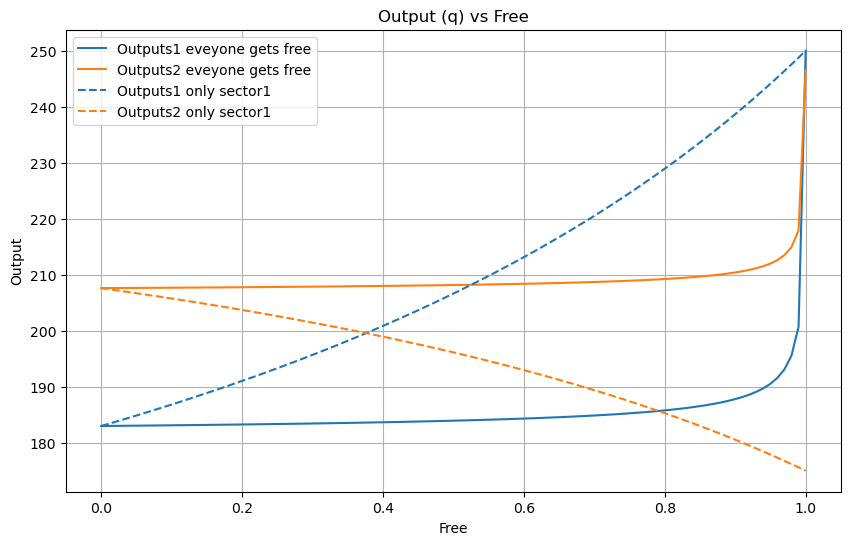

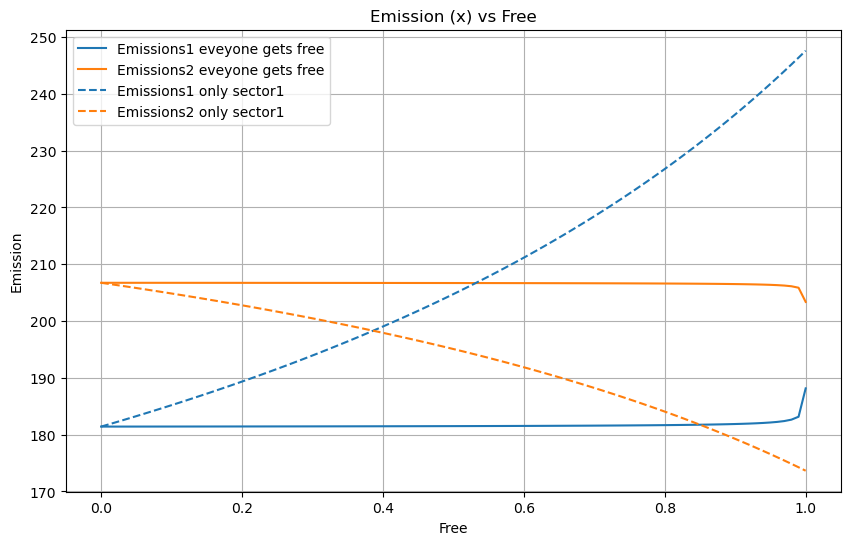

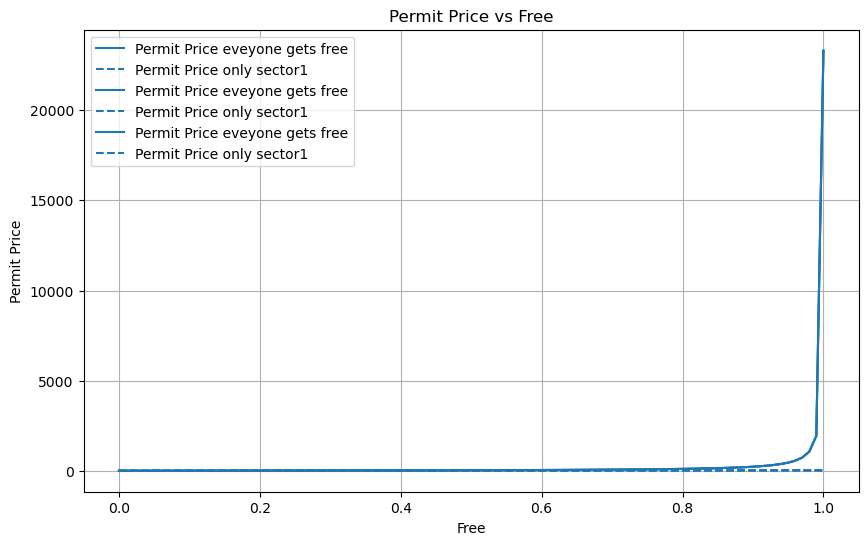

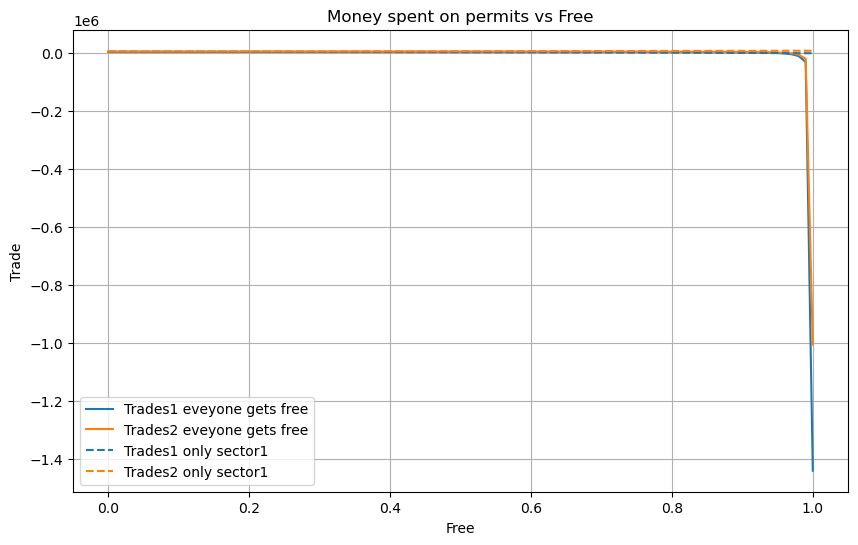

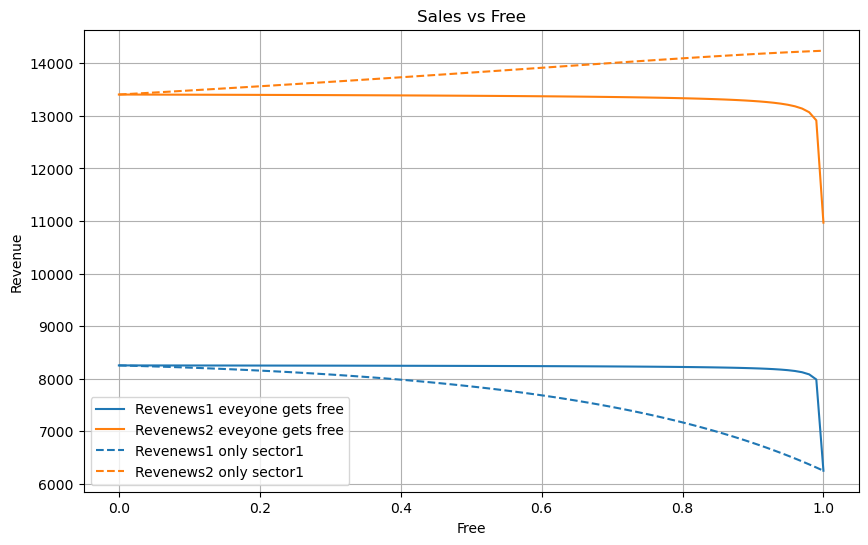

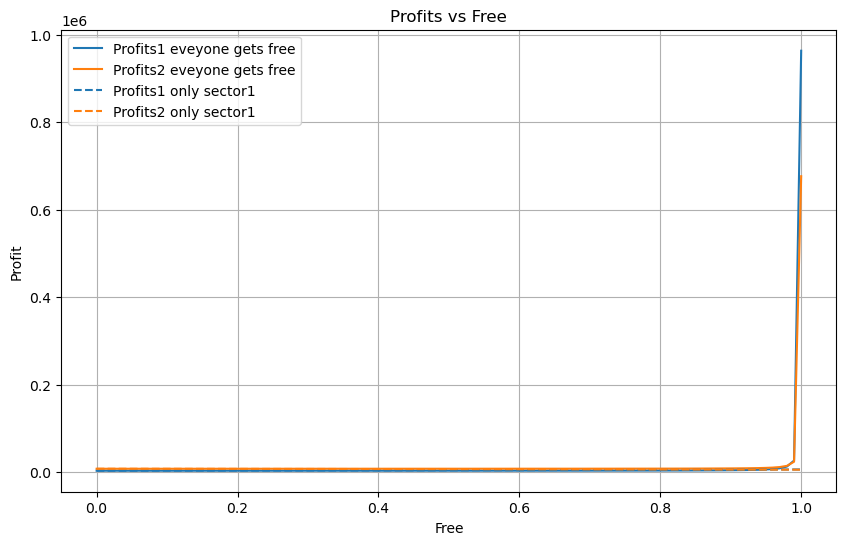

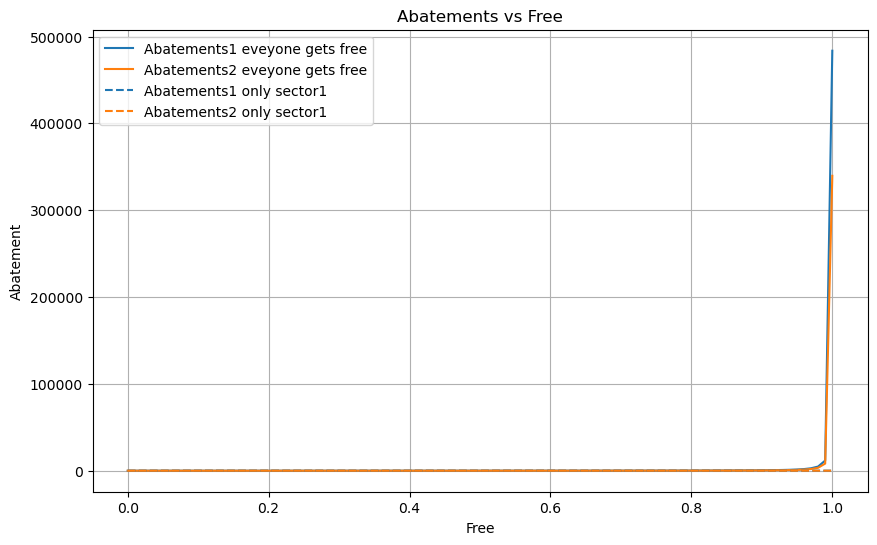

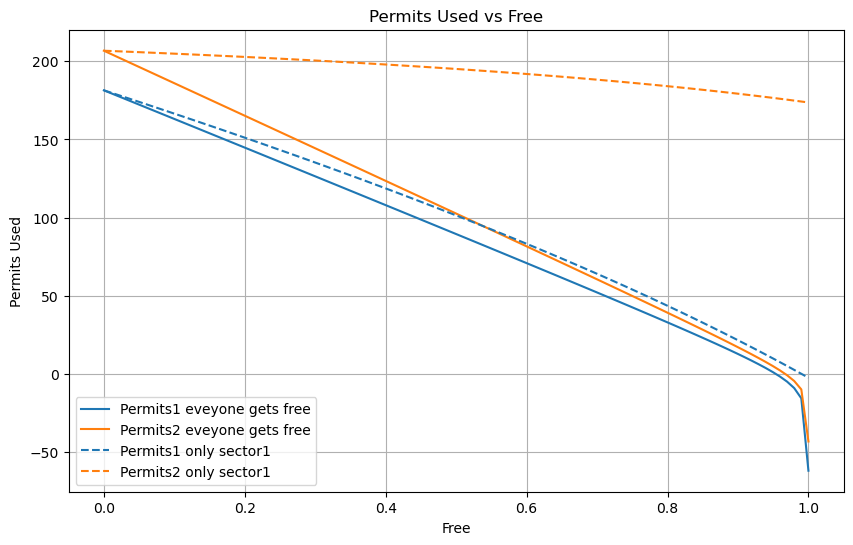

In [8]:
# Define colors and transparency levels
colors = {'trades1': '#1f77b4', 'trades2': '#ff7f0e'}


# Define a function to plot the metrics
def plot_metric(metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.plot(frees, results[True][f'{metric}1'], label=f'{metric.capitalize()}1 eveyone gets free', color=colors['trades1'])
    plt.plot(frees, results[True][f'{metric}2'], label=f'{metric.capitalize()}2 eveyone gets free', color=colors['trades2'])
    plt.plot(frees, results[False][f'{metric}1'], label=f'{metric.capitalize()}1 only sector1', color=colors['trades1'], linestyle='--')
    plt.plot(frees, results[False][f'{metric}2'], label=f'{metric.capitalize()}2 only sector1', color=colors['trades2'], linestyle='--')
    plt.xlabel('Free')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot outputs
plot_metric('outputs', 'Output', 'Output (q) vs Free')

# Plot emissions
plot_metric('emissions', 'Emission', 'Emission (x) vs Free')

# Plot permit prices
plt.figure(figsize=(10, 6))
for perc in [0.7, 0.8, 0.9]:
    plt.plot(frees, results[True]['permit_price'], label=f'Permit Price eveyone gets free', color=colors['trades1'])
    plt.plot(frees, results[False]['permit_price'], label=f'Permit Price only sector1', color=colors['trades1'], linestyle='--')
plt.xlabel('Free')
plt.ylabel('Permit Price')
plt.title('Permit Price vs Free')
plt.legend()
plt.grid()
plt.show()

# Plot trades
plot_metric('trades', 'Trade', 'Money spent on permits vs Free')

# Plot revenues
plot_metric('revenews', 'Revenue', 'Sales vs Free')



# Plot profits
plot_metric('profits', 'Profit', 'Profits vs Free')

# Plot abatements
plot_metric('abatements', 'Abatement', 'Abatements vs Free')

# Plot permits used
plot_metric('permits', 'Permits Used', 'Permits Used vs Free')

